In [1]:
import os
import mne
import matplotlib.pyplot as plt
import numpy as np

In [2]:
rootDir = 'D:/gtech_hackathon_2024'
dataDir = os.path.join(rootDir, 'SSVEP_Data')

In [3]:
sjNum = 1
training = 1

# Data File Description

* Stimulation frequencies: 9, 10, 12 and 15 Hz (column 1, 2, 3 and 4 in classInfo_4_5.m)
* Sampling rate: 256 Hz 
* CH1: sample time 
* CH2-9: EEG 
* CH10: trigger info (LED on...1, LED off...0); 
* CH11: LDA classification output 

In [4]:
raw = mne.io.read_raw_edf(os.path.join(dataDir, f'subject_{sjNum}_fvep_led_training_{training}.EDF'))

Extracting EDF parameters from D:\gtech_hackathon_2024\SSVEP_Data\subject_1_fvep_led_training_1.EDF...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


## Extract events
"Subjects were seated in front of the SSVEP box shown in
Figure 2 and were asked to focus on the target LED for 7 s, after
which the trial ended and the lights on the SSVEP box turned off. The top LED was designated as the target for the first five trials,
followed by five trials for the right LED, then the bottom LED, then
the left LED. After these 20 trials ended, the classifier was trained on
the resulting data while subjects took a short break. This training
procedure (recording data and training the classifier) took about
5 min."

In [5]:
events = mne.find_events(raw, stim_channel = '10')

20 events found on stim channel 10
Event IDs: [1]


In [6]:
# based on classInfo_4_5.m
y = np.tile(np.arange(4), 5)

In [7]:
events[:, 2] = y

LED postions:
1. Top: 9 Hz
2. Right: 10 Hz
3. Bottom: 12 Hz
4. Left: 15 Hz


In [8]:
mapping = {0:'9', 1:'10', 2:'12', 3:'15'}

annot_from_events = mne.annotations_from_events(
    events=events,
    event_desc=mapping,
    sfreq=raw.info["sfreq"],
    orig_time=raw.info["meas_date"],
)

In [9]:
raw.set_annotations = annot_from_events

In [12]:
epoch = mne.Epochs(raw, events=events, tmin=-3, tmax=7)

Not setting metadata
20 matching events found
Setting baseline interval to [-3.0, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated


In [13]:
data = epoch.get_data()

Loading data for 20 events and 2561 original time points ...
0 bad epochs dropped


In [14]:
t = np.arange(-3, 7+1/256, 1/epoch.info['sfreq'])

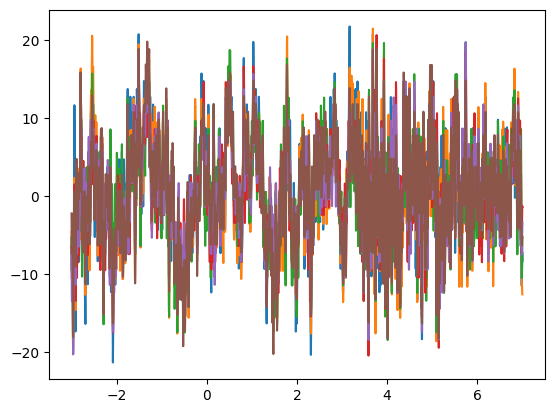

In [22]:
plt.plot(t, data[0, 1:9, :].T)
plt.show()

In [ ]:
# extract only eeg channels
data = data[:, 2:9, :]

In [ ]:
erp = data.reshape(4, -1, data.shape[1], len(t)).mean(axis=1)

# Goal: 
* Sliding window classification using max 3s of data
* Include a "no attended" label?

In [16]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from pyriemann.estimation import BlockCovariances
from pyriemann.utils.mean import mean_riemann
from pyriemann.classification import MDM
from scipy.signal import butter, filtfilt
from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold

In [17]:
import math

In [18]:
# use only eeg channels
data = epoch.get_data()
data = data[:, 2:9]
t = np.arange(-3, 7+1/256, 1/epoch.info['sfreq'])

Loading data for 20 events and 2561 original time points ...


In [19]:
nTrials = data.shape[0]
nChans = data.shape[1]
nTimepoints = data.shape[2]

In [20]:
srate = epoch.info['sfreq']

In [21]:
data = mne.filter.notch_filter(data, Fs=srate, freqs=50)

Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 1691 samples (6.605 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s


In [ ]:
# filter data around frequency bands
f_bands = np.asarray([9, 10, 12, 15])
nFbands = len(f_bands)*3
data_filt = np.zeros((nFbands, data.shape[0], data.shape[1], data.shape[2]))
cnt = 0

for iBand, band_c in enumerate(f_bands):
    for iHarmonic in range(3):
        band_c *= (iHarmonic+1)
        b, a = butter(5, Wn=(band_c-0.1, band_c+0.1), fs=srate, btype='bandpass')
        data_filt[cnt, :] = filtfilt(b, a, data)
        cnt += 1

In [ ]:
data_filt = data_filt.reshape(-1, nFbands*nChans, nTimepoints)

In [ ]:
data_filt.shape

In [ ]:
# use only 0-7s as the training data
data_filt_stim = data_filt[:, :, abs(t-0).argmin():abs(t-7).argmin()]
nTimepoints = data_filt_stim.shape[-1]

In [25]:
tWindow_s = 1
win_size = len(np.arange(0, tWindow_s, 1/srate))
delta = 1-0.90
w_overlap = math.floor(win_size * delta) if math.floor(win_size * delta) else 1
tWindow_startIdxs = np.arange(0, nTimepoints-win_size, w_overlap)
nWindows = len(tWindow_startIdxs)

In [ ]:
# crop data into sliding windows
X = np.zeros((nTrials, nWindows, nFbands*nChans, win_size))
y_aug = np.zeros((nTrials, nWindows))
y = np.tile(np.arange(4), 5)
for iTrial in range(nTrials):
  for iCrop, w_start in enumerate(tWindow_startIdxs):
    w_end = w_start + win_size
    X[iTrial,iCrop, :] = data_filt_stim[iTrial, :, w_start:w_end]
    y_aug[iTrial,iCrop] = y[iTrial]
    

In [ ]:
X = X.reshape(-1, nChans*nFbands, win_size)
y = y_aug.flatten()

In [ ]:
cov_est_trials = BlockCovariances(estimator='lwf', block_size=nChans*3).transform(X)

In [ ]:
plt.imshow(cov_est_trials[1200, :])
plt.show()

In [ ]:
cv = RepeatedStratifiedKFold(n_splits=2, n_repeats=10, random_state=23)

In [ ]:
clf = MDM(metric=dict(mean='riemann', distance='riemann'))

In [ ]:
scores = cross_val_score(clf, cov_est_trials, y, cv=cv)

In [ ]:
scores.mean()

In [ ]:
type(epoch) == mne.epochs.Epochs

In [ ]:
epoch.events[:, 2]

In [ ]:
data_filt.shape[-2:]

In [ ]:
data.ndim

In [ ]:
from Analysis_Scripts.utils import load_and_epoch, epoch_slidingWindow_DA

In [ ]:
data_filt_stim.shape

In [ ]:
fooX, fooY = epoch_slidingWindow_DA(data_filt, t[abs(t-0).argmin():abs(t-7).argmin()], 
                                    labels = np.tile(np.arange(4), 5))

In [ ]:
foo_epoch = load_and_epoch(os.path.join(dataDir, f'subject_{sjNum}_fvep_led_training_{training}.EDF'))

In [ ]:
foo_epoch.events[:,2]

In [ ]:
np.setdiff1d([1,2], 2)

# MEC

In [83]:
def mininum_entropy_combination(data, freqs, nTimepoints, Fs, nHarmonics=6):

    X = []
    t = (np.arange(nTimepoints)+1)/Fs
    for k in range(1, nHarmonics+1):
        # sin and cosine wave of stimulation frequencies
        sub_X = np.zeros((nTimepoints, 2))
        for f in freqs:
            sub_X[:, 0] = np.sin(2*np.pi*f*k*t)
            sub_X[:, 1] = np.cos(2*np.pi*f*k*t)
            X.append(sub_X)
            
    X = np.hstack(X)

    # Compute nuisance signals in data
    # Y_nuisance = Y - X*pinv(X.T*X)*X.T*Y

    # check dimensions of data
    # channels should be last dimension
    if data.ndim == 3:
        n, tt, c = data.shape
    else:
        tt, c = data.shape

    # incase time is last dimension
    if c == nTimepoints:
        if data.ndim == 3:
            data = data.swapaxes(1,-1)
        else:
            data = data.T

    inv_term = X @ np.linalg.pinv(X.T @ X)
    nuisance = data - inv_term @ X.T @ data

    # apply PCA to nuisance matrix and remove nuisance singals from real data
    pca = PCA()
    data_cleaned = np.zeros((data.shape))
    if data.ndim == 3:
        for i in range(n):
            pca.fit(nuisance[i,:])
            data_cleaned[i, :] = pca.transform(data[i, :])
    else:
        pca.fit(nuisance)
        data_cleaned = pca.transform(data)

    return data_cleaned
        

In [29]:
stim_freqs = np.array([9, 10, 12, 15])
nHarmonics = 6
ssvep_model_X = []
model_t = (np.arange(256)+1)/srate
for k in range(1, nHarmonics+1):
    # sin an cosine waves of ssvep
    model_subX = np.zeros((len(model_t), 2))
    for f in stim_freqs:
        model_subX[:,0] = np.sin(2*np.pi*f*k*model_t)
        model_subX[:,1] = np.cos(2*np.pi*f*k*model_t)
        ssvep_model_X.append(model_subX)

In [30]:
ssvep_model_X = np.hstack(ssvep_model_X)

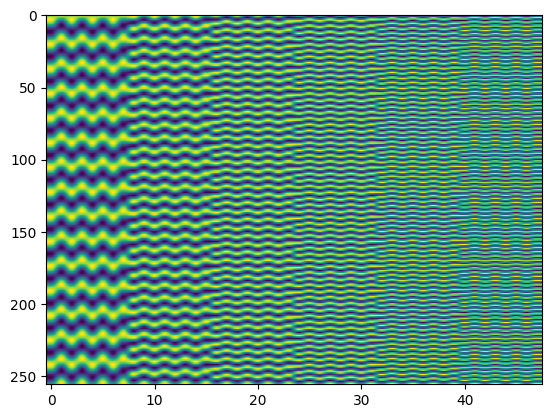

In [34]:
plt.imshow(ssvep_model_X, aspect='auto')
plt.show()

In [53]:
foo_foo = (ssvep_model_X.T @ data[:,:,:win_size].swapaxes(1,-1))

In [47]:
foo = data[0, :, :win_size]

In [55]:
foo_foo_foo = (ssvep_model_X.T @ foo.T)

In [70]:
Y_nuisance = data[:,:,:win_size].swapaxes(1,-1) - ((ssvep_model_X @ np.linalg.pinv(ssvep_model_X.T @ ssvep_model_X)) @ foo_foo)

In [74]:
from sklearn.decomposition import PCA

In [76]:
pca = PCA()

In [77]:
pca.fit(Y_nuisance[0,:])

PCA()

In [81]:
data_foo = pca.transform(data[0,:,:win_size].T).T

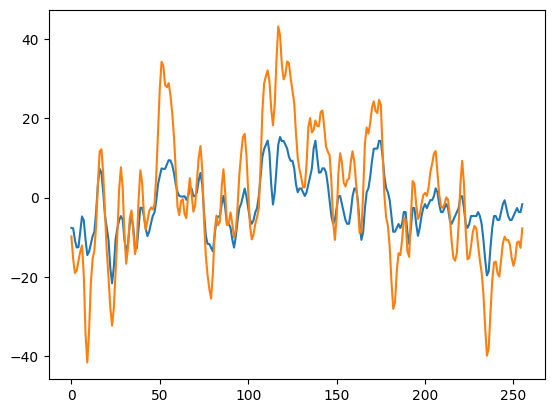

In [82]:
plt.plot(data[0,0,:win_size])
plt.plot(data_foo[0,:])
plt.show()

In [85]:
data_cleaned = mininum_entropy_combination(data, stim_freqs, len(t), srate, nHarmonics=6)

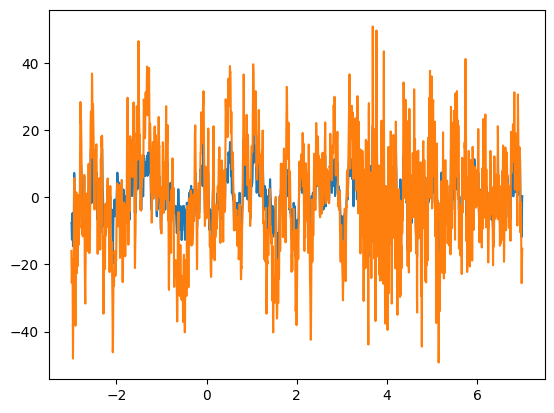

In [87]:
plt.plot(t, data[0, 0, :])
plt.plot(t, data_cleaned[0,:,0])
plt.show()

In [88]:
foon = {0:'9', 1:'10', 2:'12', 3:'15'}

array([ 9., 10., 12., 15.])